In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata_allcells = sc.read_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['leiden_lab_orig'].isin(['Mast cells']), :]
adata

View of AnnData object with n_obs × n_vars = 2634 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [6]:
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 2634 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group'],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
sc.pl.umap(adata, color = ["Group"])

# 2. Determine optimal cluster resolution for cell subset annotation

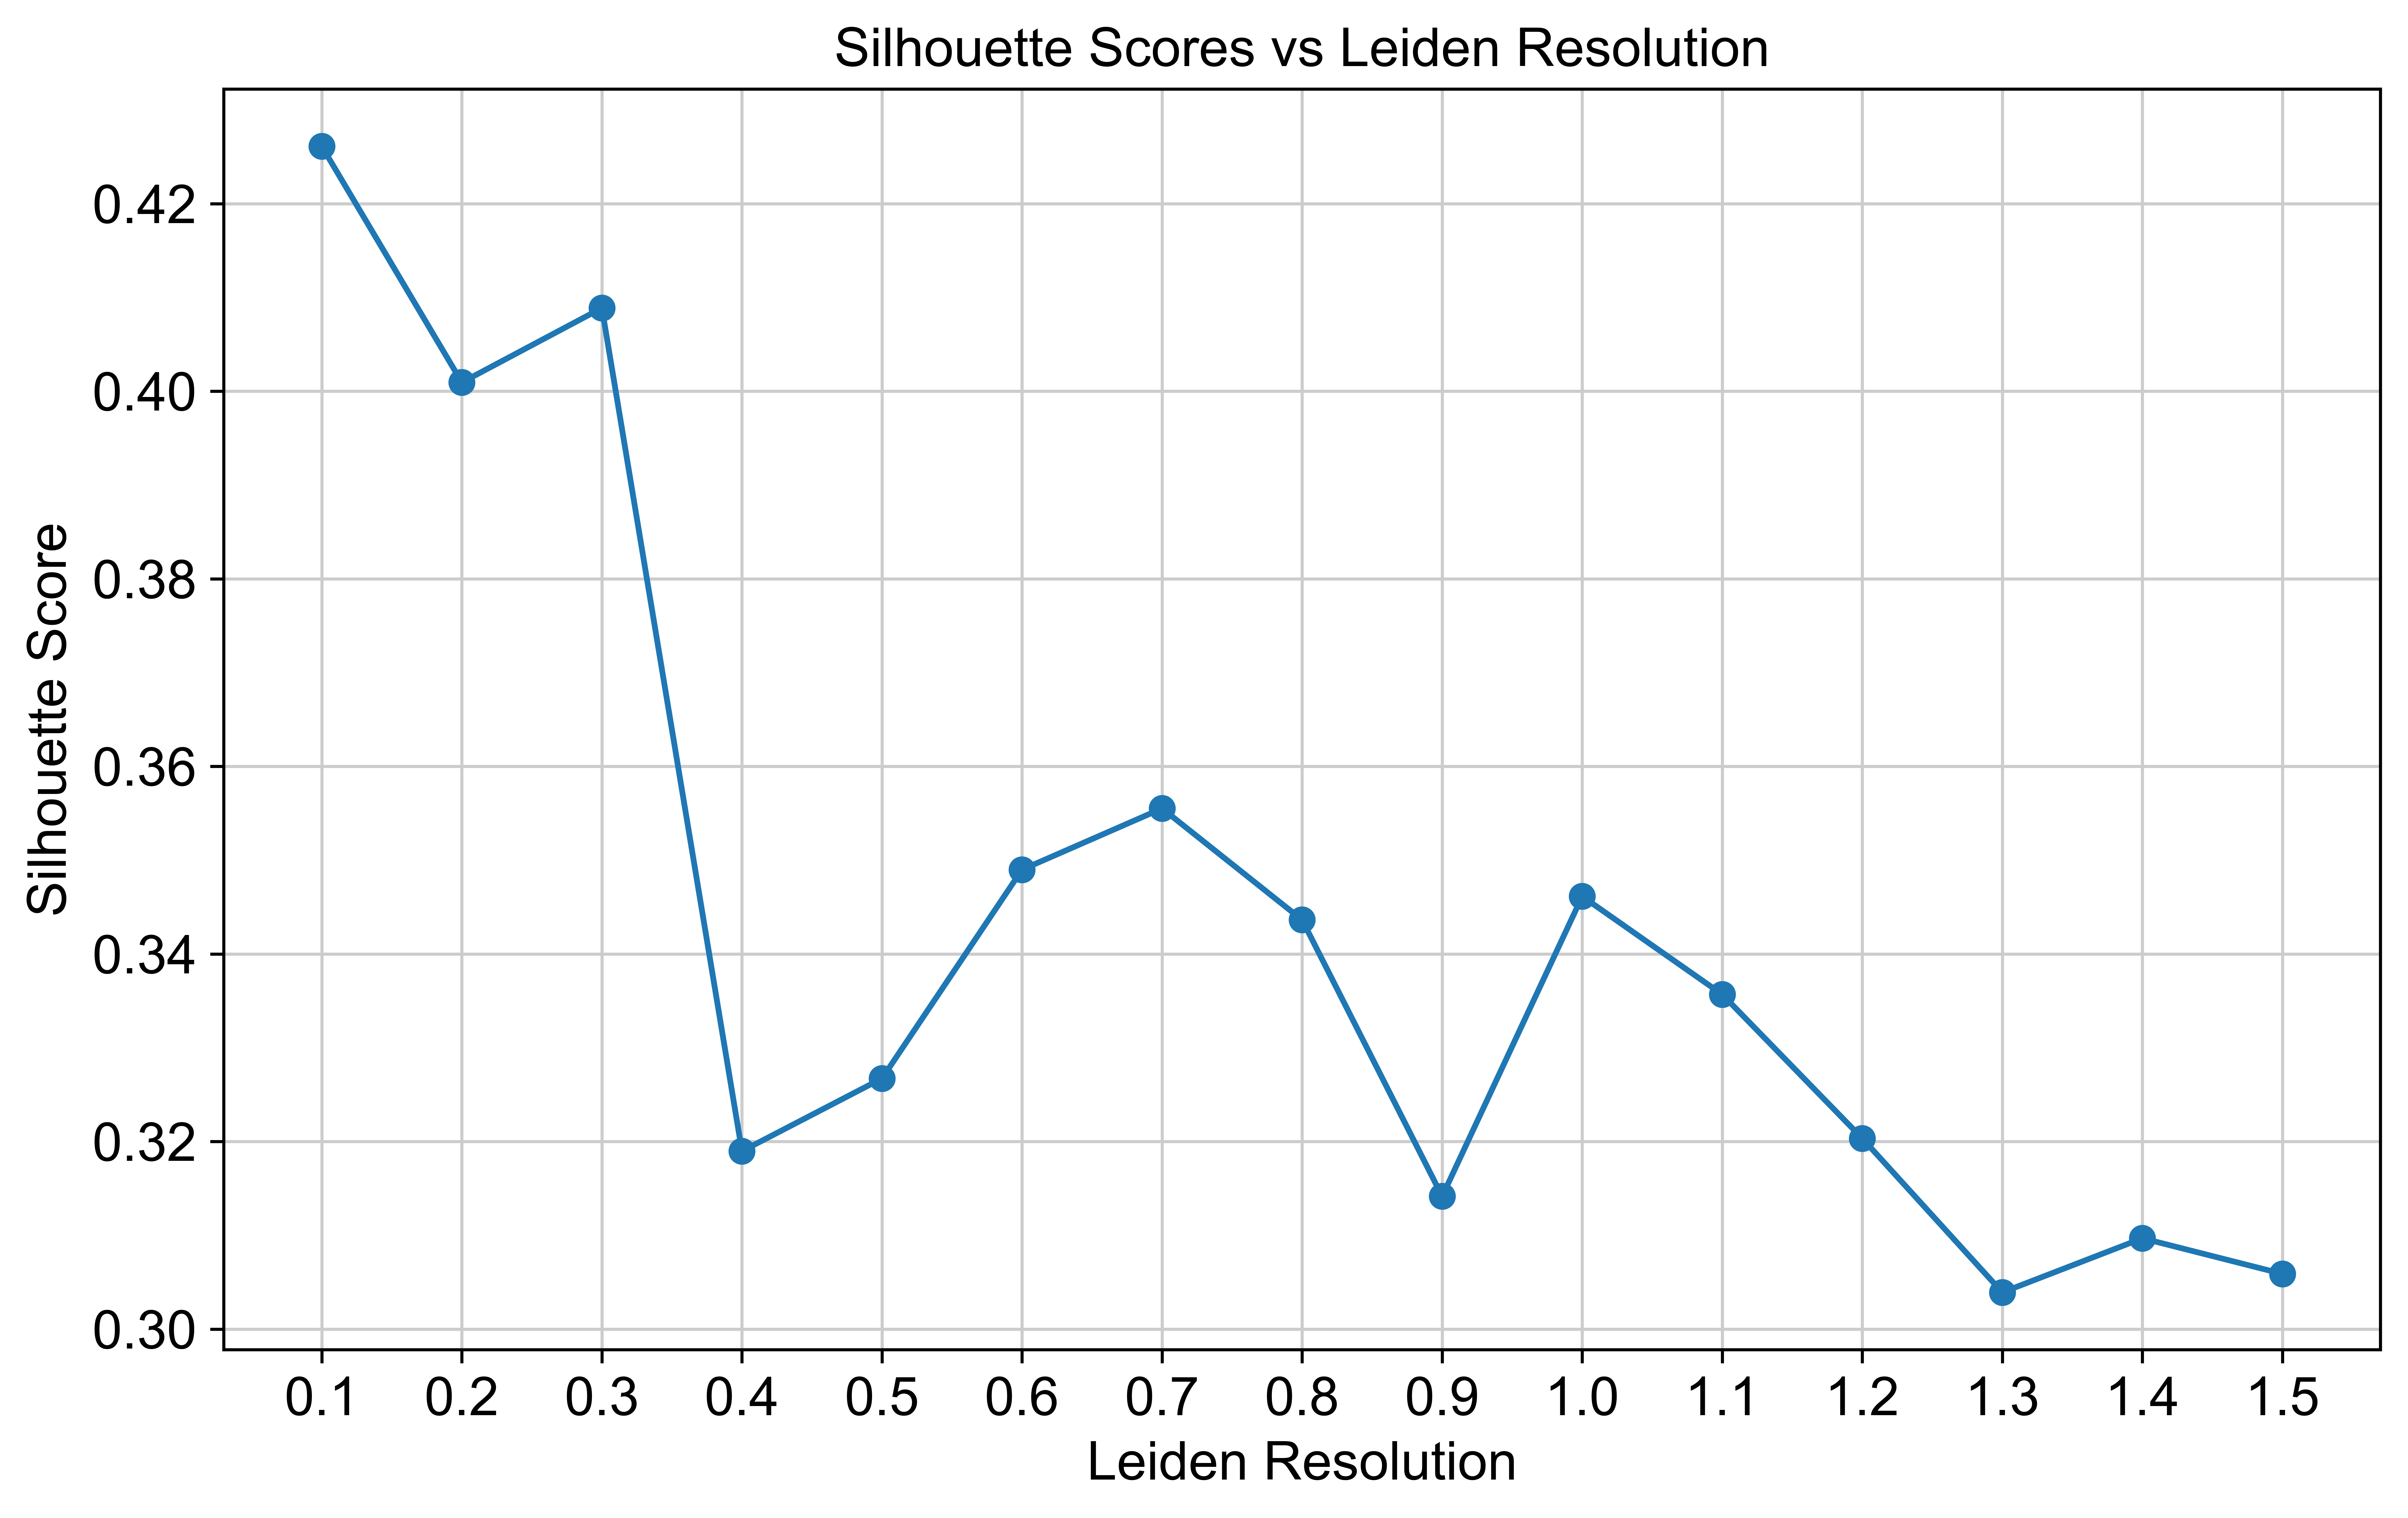

In [10]:
import sklearn
from sklearn.metrics import silhouette_score  
# define resolutions to be tested
resolutions = [0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

silhouette_scores = []

# calculate silhouette scores for each resolution
for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f"leiden_res{res}")
    
    score = sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs[f"leiden_res{res}"], metric='euclidean')
    silhouette_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(resolutions, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Leiden Resolution')
plt.xlabel('Leiden Resolution')
plt.ylabel('Silhouette Score')
plt.xticks(resolutions)
plt.grid(True)
plt.show()


leiden_res0.2 is stable and has resolved a few clusters with biological significance


In [ ]:
sc.pl.umap(adata, color = ["leiden_res0.2"],legend_loc='on data')

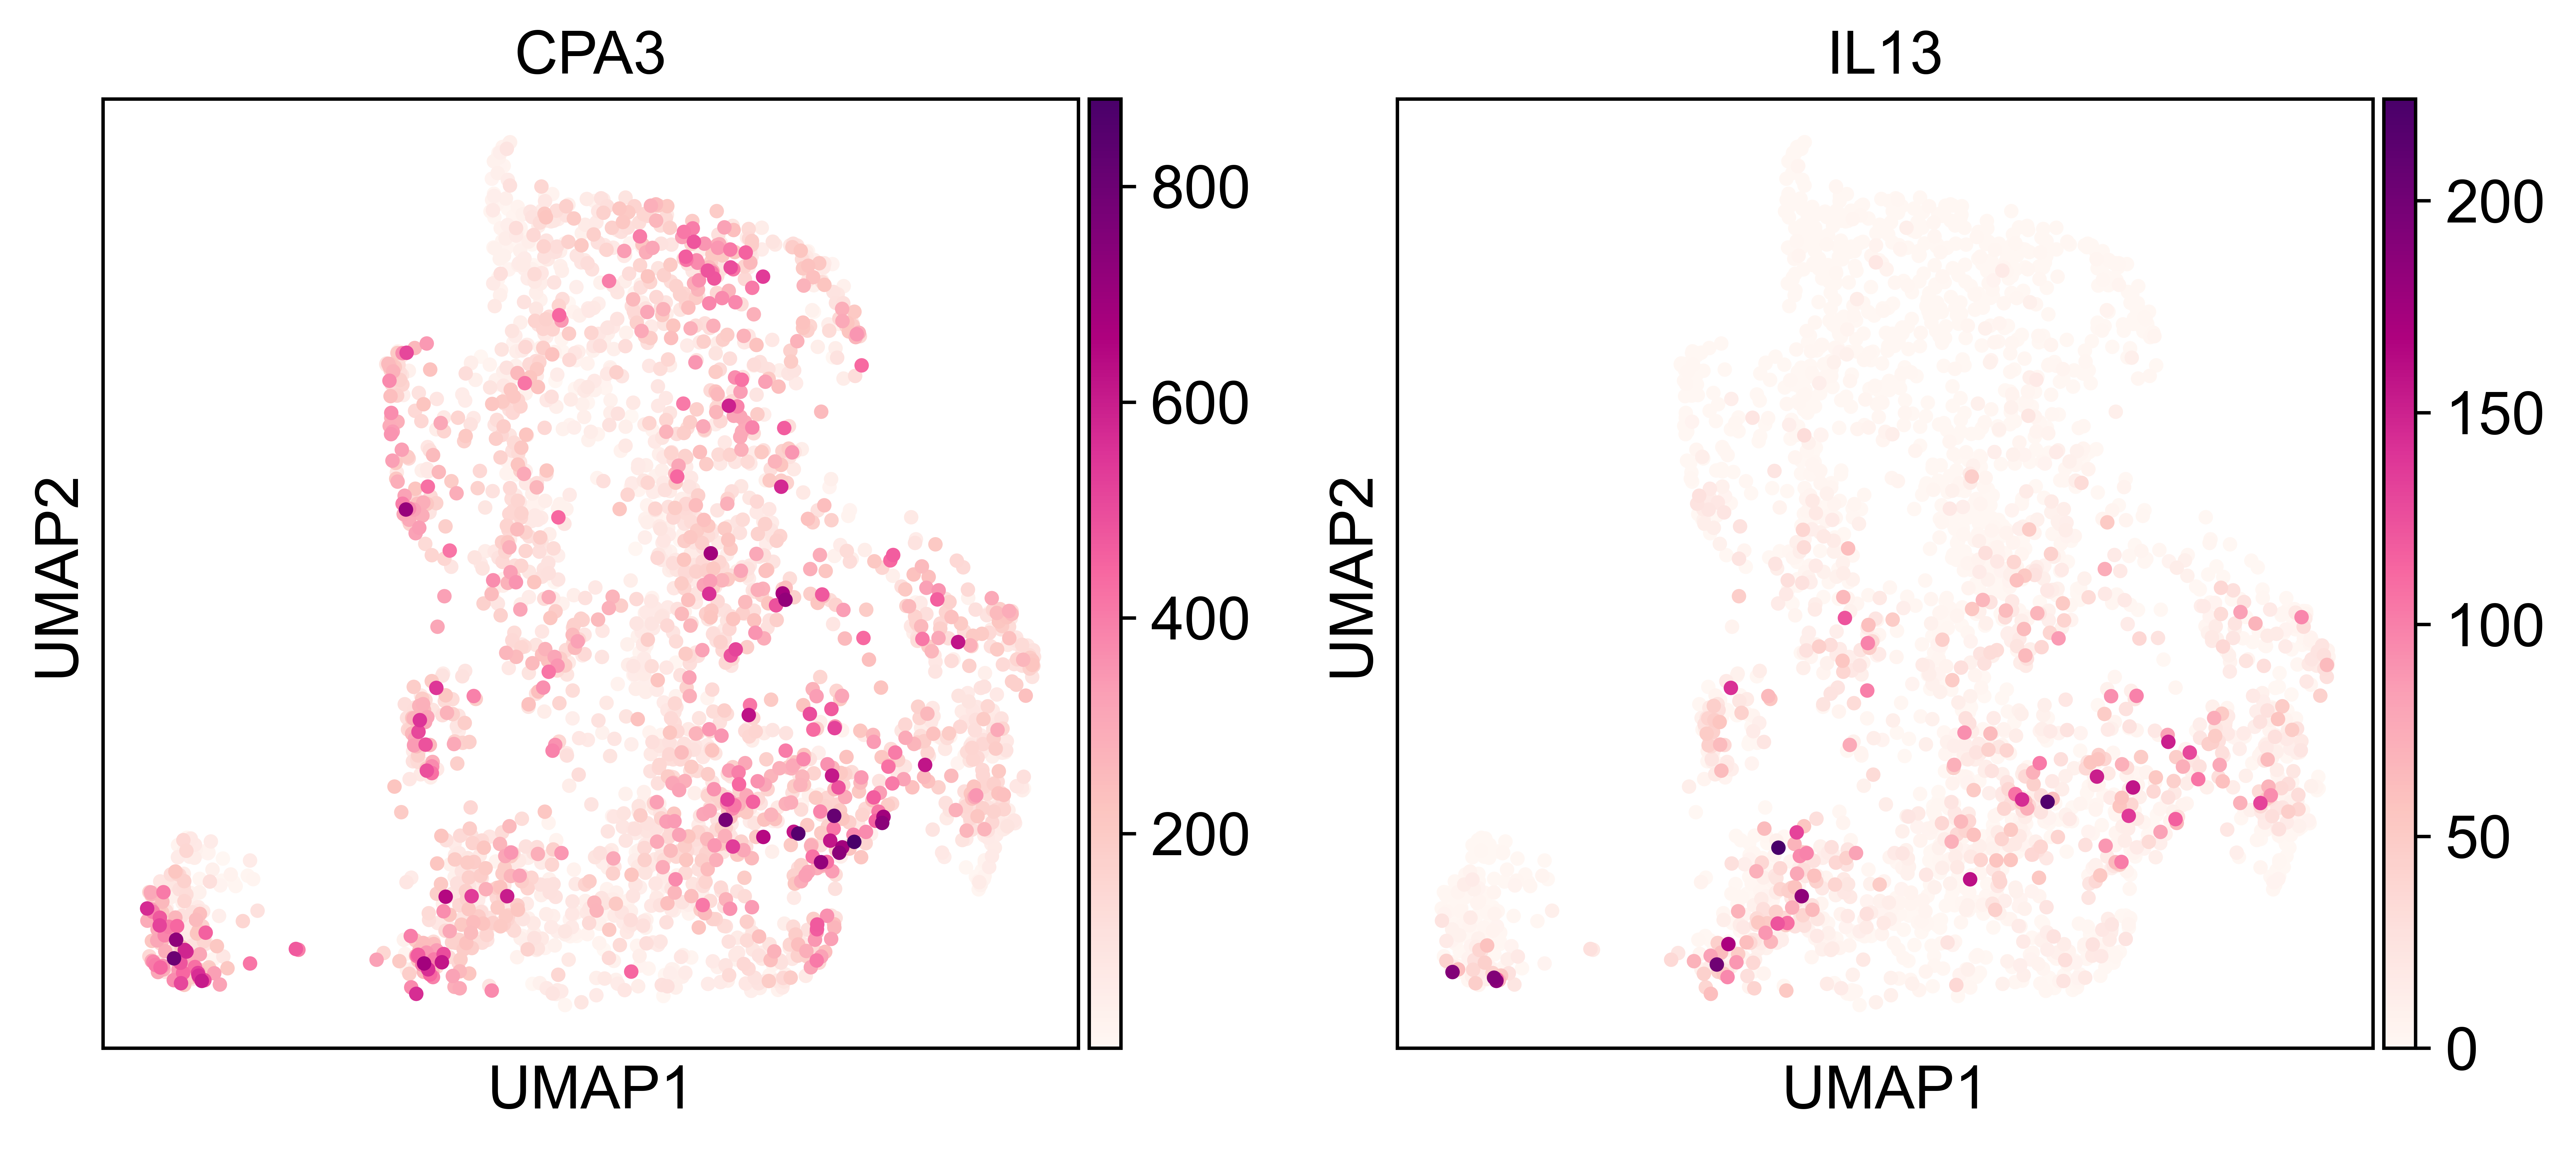

In [15]:
sc.pl.umap(adata, color = ["CPA3","IL13"],legend_loc='on data')

In [14]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden_res0.2', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))

0             1             2
0       LMNA           FOS         MKI67
1    TNFAIP3           JUN         STMN1
2       ELL2          RGS1          TUBB
3      MAPK6  LOC101925240         TOP2A
4      BIRC3         DUSP1          RRM2
5      ARL5B          IER2  LOC102130495
6       CREM         TXNIP         CENPF
7      NR4A3         ZFP36  LOC107126576
8   PPP1R15A       FAM212A          SMC2
9    TP53BP2       TSC22D3         NCAPG
10      IL13        LHFPL2          SMC4
11    NFE2L2          GFI1         HMGB2
12    NFKBIA       PIK3IP1          PRC1
13    MTHFD2          MLPH         KIF11
14      EGR3         RSRP1        TUBA1B
15     GRASP        ZMYND8         BIRC5
16     VEGFA        MARCH1         SPAG5
17       REL      SLC25A30          TMPO
18     TRAF1        MAP3K1         CENPM
19   GNPNAT1        CITED2         CCNA2

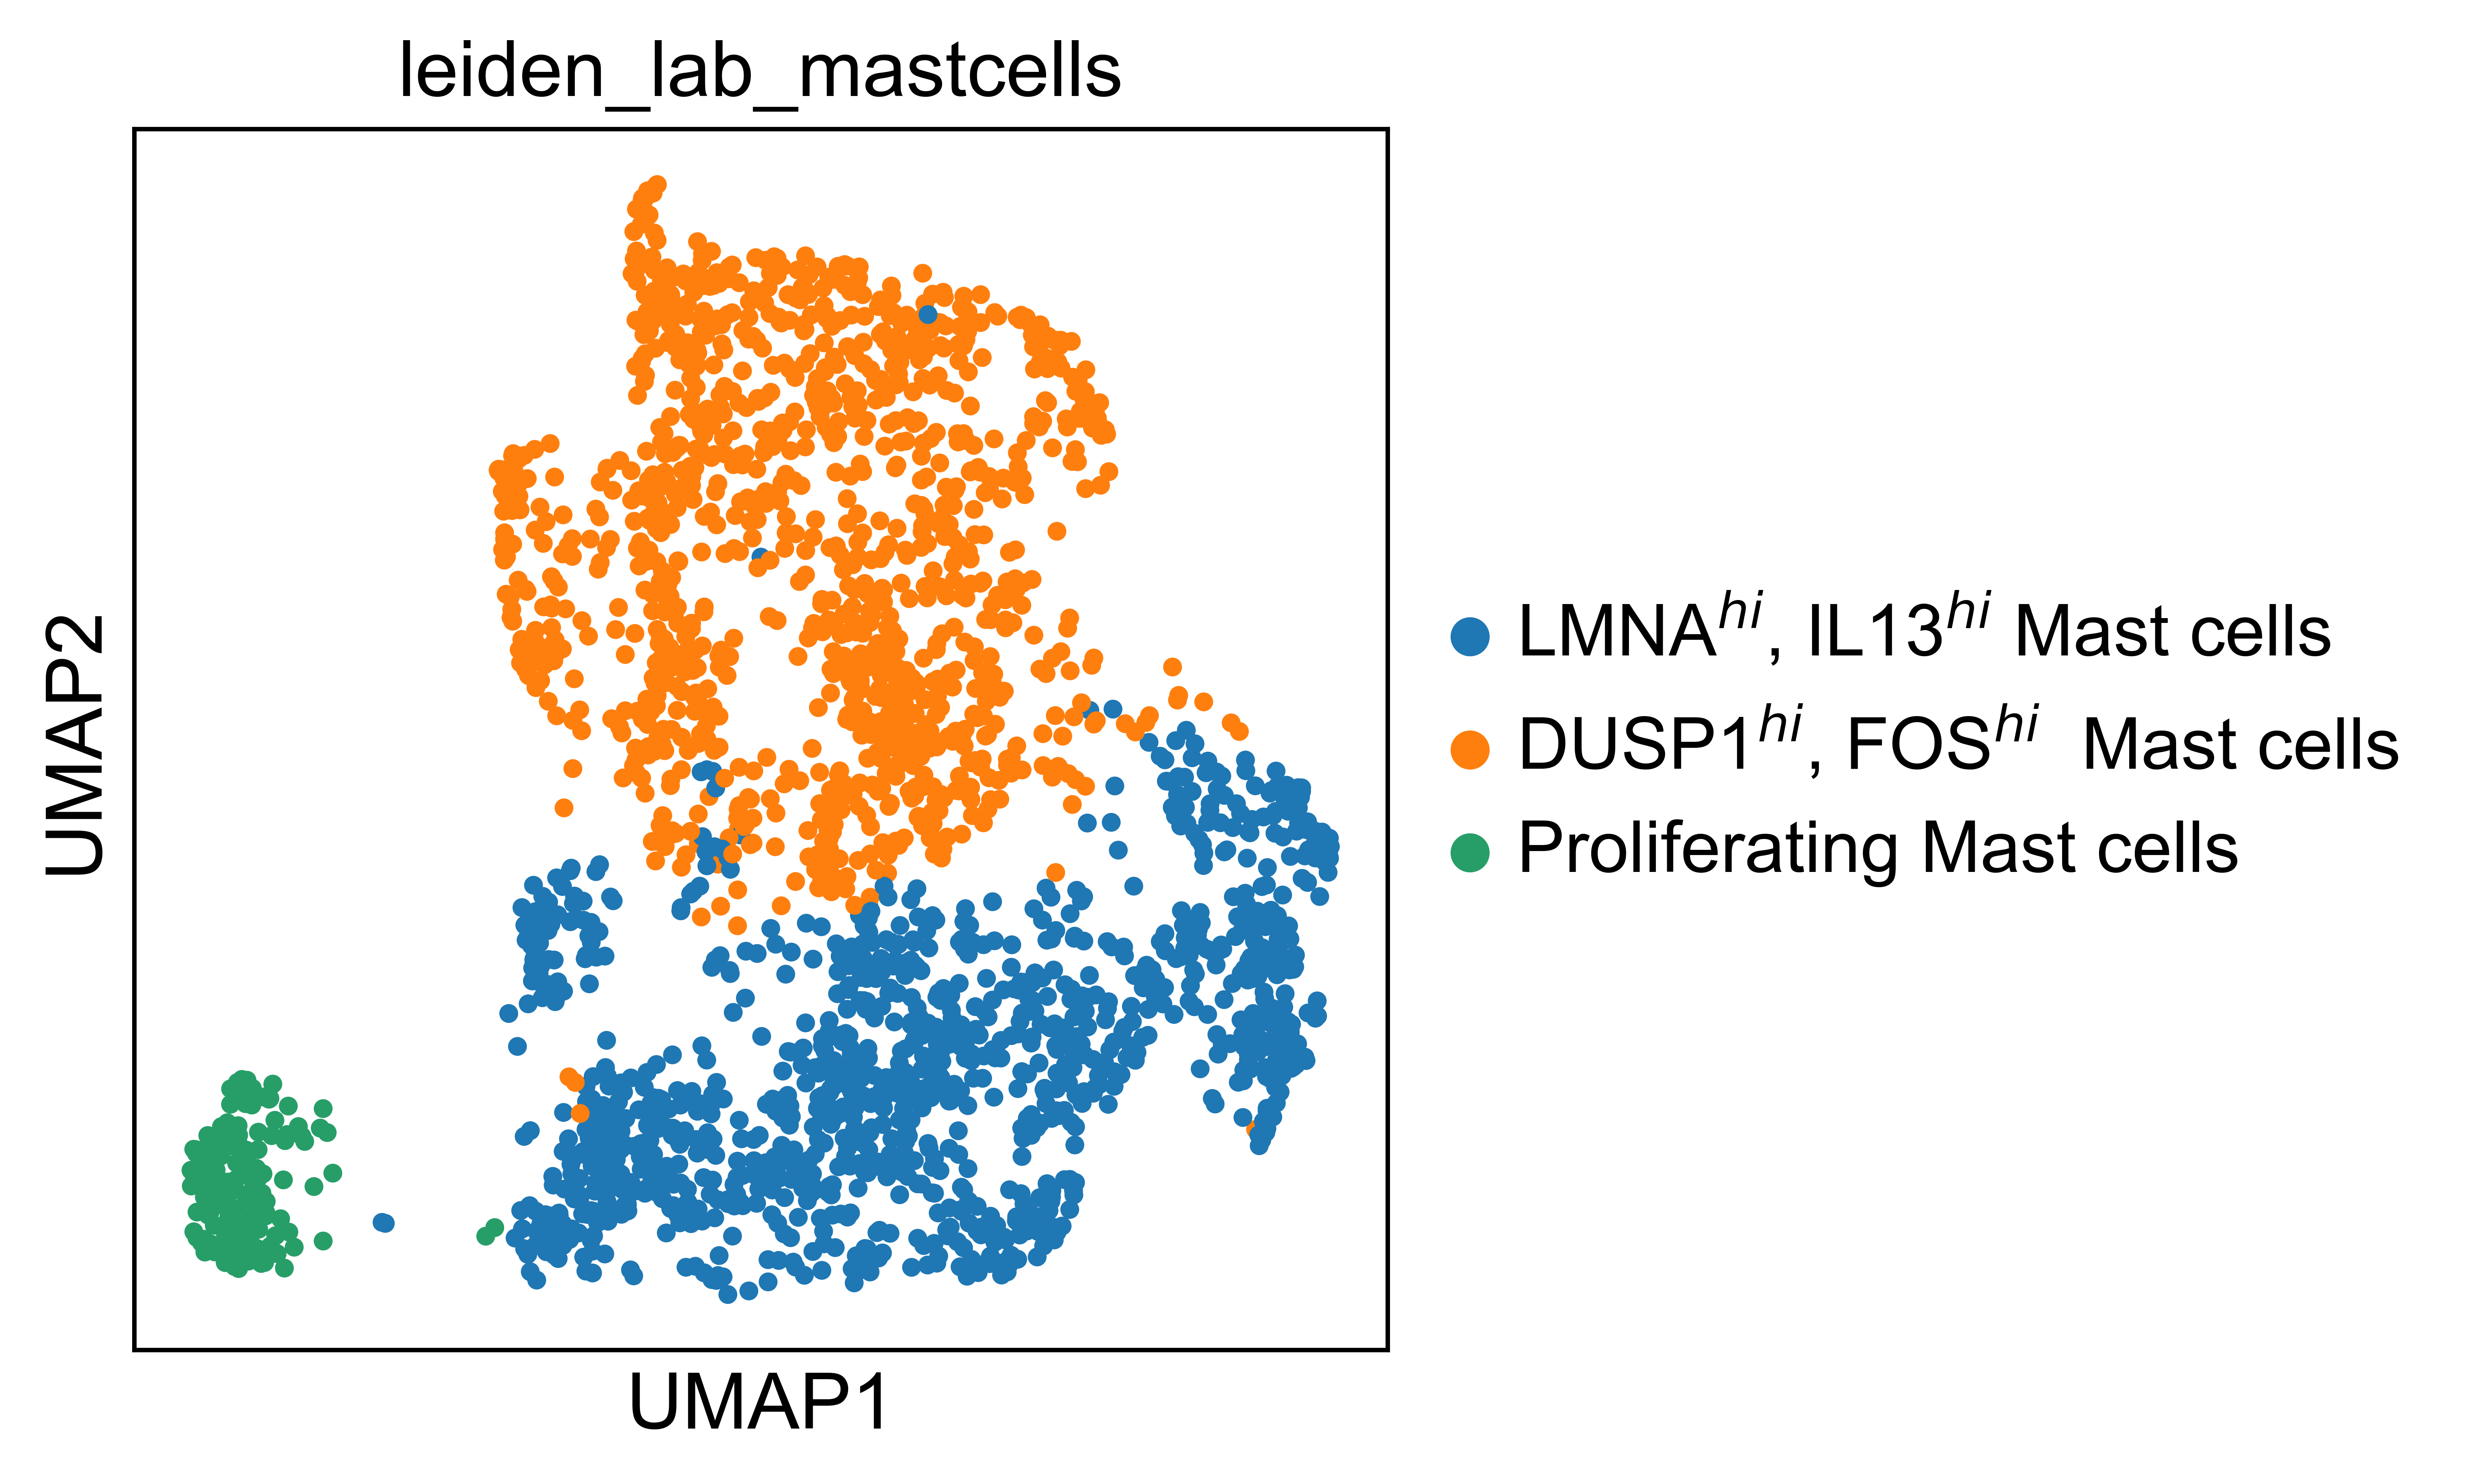

In [17]:
labmap2 = {'0':'LMNA$^{hi}$, IL13$^{hi}$ Mast cells',
          '1':'DUSP1$^{hi}$, FOS$^{hi}$  Mast cells',
          '2':'Proliferating Mast cells '}
adata.obs['leiden_lab_mastcells'] = adata.obs['leiden_res0.2'].replace(labmap2)
sc.pl.umap(adata, color=['leiden_lab_mastcells'])


In [19]:
adata_allcells.obs['Subclustering'] = adata_allcells.obs['Subclustering'].astype(str)
adata_allcells.obs.loc[adata.obs.index, 'Subclustering'] = adata.obs['leiden_lab_mastcells']
#Save adata_allcells h5ad file w/subclustering idents
adata_allcells.write_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
